In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from analysis.plot_matplotlib import plot_hist
from analysis.mc import BinnedImportanceSamplingIntegrator
from analysis import tnp, tnp_mode
import pandas as pd

tnp_mode(1);

# NF example

In [2]:
from analysis.mc import ImportanceSamplingIntegrator

In [3]:
class NFlowImportanceSamplingIntegrator(ImportanceSamplingIntegrator):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        
    def sample(self, n_samples:int=1, with_importance:bool=False):
        pass
    
    def adapt(self, n_samples:int=1000000):
        self.adapted = True
        pass

In [4]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
from analysis.nis.distributions import HyperUniform
import numpy as np
import pandas as pd

In [6]:
from normflows.distributions import BaseDistribution
from typing import Optional

class HyperUniform(BaseDistribution):
    """
    Multivariate uniform distribution
    """

    def __init__(self, low, high, dtype=torch.float, device:Optional[str]=None):
        """Constructor

        Args:
          low: Lower bound of uniform distribution
          high: Upper bound of uniform distribution
        """
        
        low = torch.tensor(low).to(dtype)
        high = torch.tensor(high).to(dtype)
        
        if device is not None:
            low = low.to(device)
            high = high.to(device)
        
        assert(low.shape == high.shape)
        
        shape = low.shape[0]
        
        super().__init__()
        if isinstance(shape, int):
            shape = (shape,)
        if isinstance(shape, list):
            shape = tuple(shape)
            
        self.shape = shape
        self.d = np.prod(shape)
        self.low = low
        self.high = high
        self.log_prob_val = -torch.sum(torch.log(self.high - self.low))

    def forward(self, num_samples=1, context=None):
        eps = torch.rand(
            (num_samples,) + self.shape, dtype=self.low.dtype, device=self.low.device
        )
        z = self.low + (self.high - self.low) * eps
        log_p = self.log_prob_val * torch.ones(num_samples, device=self.low.device)
        return z, log_p

    def log_prob(self, z, context=None):
        return torch.ones(z.shape[0], device=z.device)
        log_p = self.log_prob_val * torch.ones(z.shape[0], device=z.device)
        out_range = torch.logical_or(z < self.low, z > self.high)
        ind_inf = torch.any(torch.reshape(out_range, (z.shape[0], -1)), dim=-1)
        log_p[ind_inf] = -np.inf
        return log_p

In [7]:
import normflows as nf
import torch
from typing import Optional, Callable

def print_model_summary(model):
    print(
        'Model: %s\nParameters: %i' %
        (model, sum(p.numel() for p in model.parameters()))
    )

def get_nfm(q0:Optional[BaseDistribution]=None,
            K:int = 16,
            latent_size:int = 2,
            hidden_units: int = 256,
            hidden_layers:int = 2,
            cuda_if_available:bool = True,
            flow:Callable = nf.flows.AutoregressiveRationalQuadraticSpline,
            linear_permute:bool = True,
            flow_args:dict = {'num_bins': 30,},
            seed:Optional[int]=None):
    
    if seed is not None:
        torch.manual_seed(seed)

    flows = []
    for i in range(K):
        flows += [flow(latent_size, hidden_layers, hidden_units, **flow_args)]
        if linear_permute:
            flows += [nf.flows.LULinearPermute(latent_size)]

    # Set base distribuiton
    if q0 is None:
        #q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
        q0 = nf.distributions.Uniform(latent_size)
        
    # Construct flow model
    nfm = nf.NormalizingFlow(q0=q0, flows=flows)

    print("Using device " + f"GPU ({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "CPU")
    print(f"Model with {sum(p.numel() for p in nfm.parameters())} parameters")
    
    # Move model on GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() and cuda_if_available else 'cpu')
    return nfm.to(device)

In [8]:
low=[-2,-2]
high=[2, 2]

(array([[36., 26., 24., ..., 24., 28., 32.],
        [28., 27., 32., ..., 22., 24., 22.],
        [24., 27., 29., ..., 22., 30., 25.],
        ...,
        [18., 24., 22., ..., 31., 30., 25.],
        [18., 27., 19., ..., 16., 28., 31.],
        [25., 21., 28., ..., 22., 20., 32.]]),
 array([-1.99992633e+00, -1.93742750e+00, -1.87492868e+00, -1.81242985e+00,
        -1.74993102e+00, -1.68743220e+00, -1.62493337e+00, -1.56243454e+00,
        -1.49993572e+00, -1.43743689e+00, -1.37493806e+00, -1.31243924e+00,
        -1.24994041e+00, -1.18744158e+00, -1.12494276e+00, -1.06244393e+00,
        -9.99945104e-01, -9.37446278e-01, -8.74947451e-01, -8.12448625e-01,
        -7.49949798e-01, -6.87450971e-01, -6.24952145e-01, -5.62453318e-01,
        -4.99954492e-01, -4.37455665e-01, -3.74956839e-01, -3.12458012e-01,
        -2.49959186e-01, -1.87460359e-01, -1.24961533e-01, -6.24627061e-02,
         3.61204147e-05,  6.25349469e-02,  1.25033773e-01,  1.87532600e-01,
         2.50031427e-01,  3.125

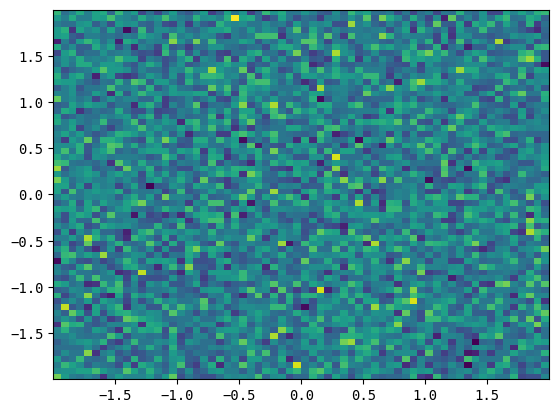

In [71]:
#a = HyperUniform(low=[-2,-2], high=[2, 2], trainable=False)
a = nf.distributions.base.Uniform(2, low=-2., high=2.)
#a = nf.distributions.base.DiagGaussian(2, trainable=False)

z = a.sample(100000)

pX = z.T[0].detach().cpu().numpy()
pY = z.T[1].detach().cpu().numpy()

plt.hist2d(pX, pY, bins=(64,64))

In [72]:
def plot_proposal(nfm, n_samples:int=1024):
    cs = nfm.sample(n_samples)
    samples = cs[0].detach().cpu().numpy()

    all_max = np.max(samples).max()
    all_min = np.min(samples).min()
    #print((all_min, all_max))

    plot_hist(pd.DataFrame(dict(x=samples.T[0], y=samples.T[1])), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max))
    if False:
        fig, ax = plt.subplots()
        ax.set_title("q0")
        for i in range(len(samples.T)):
            ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}",
                    bins=64, range=(all_min, all_max))
            ax.set_xlim(all_min, all_max)
        ax.legend()
        
def plot_integrand(nfm, func, n_samples:int=2048, vwindow=None,
                   is_nfm:bool=True, y_log:bool=False):
    if is_nfm:
        samples, log_p = nfm.sample(n_samples)
    else:
        samples = nfm.sample(n_samples)
    
    #samples = samples.detach().cpu().numpy()
    results = func(samples).detach().cpu().numpy()
    
    for i in range(len(samples.T)):
        fig, ax = plt.subplots()
        #ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}", bins=64)
        ax.scatter(x=samples.T[i].detach().cpu().numpy(),
                y=results)
        
        if vwindow is not None:
            if len(vwindow) > 2 and len(vwindow) == len(samples.T):
                ax.set_ylim(vwindow[i])
            else:
                ax.set_ylim(vwindow)
            
        ax.set_title('Integrand projection')
        ax.set_xlabel(f"Dim {i}")
        ax.set_ylabel('Integrand value')
        plt.show()
    
    fig, ax = plt.subplots()
    ax.hist(results, bins=32)
    ax.set_xlabel('Integrand value')
    if y_log:
        ax.set_yscale('log')
    ax.set_title('All results')
    
def get_result(nfm, func:Callable, n_samples:int=1024, is_nfm:bool=True):
    if is_nfm:
        samples, log_p = nfm.sample(n_samples)
        prob = log_p.exp().detach()#.cpu().numpy()
    else:
        samples = nfm.sample(n_samples)
        prob = torch.ones(n_samples) * nfm.log_prob_val.exp()
    
    res = func(samples)/prob
    
    integral = (1/n_samples * res.sum()).detach().cpu().numpy().item()
    delta = (torch.var(res).detach().cpu()/n_samples).sqrt().numpy().item()
    
    return integral, delta

CPU
Model with 1430400 parameters


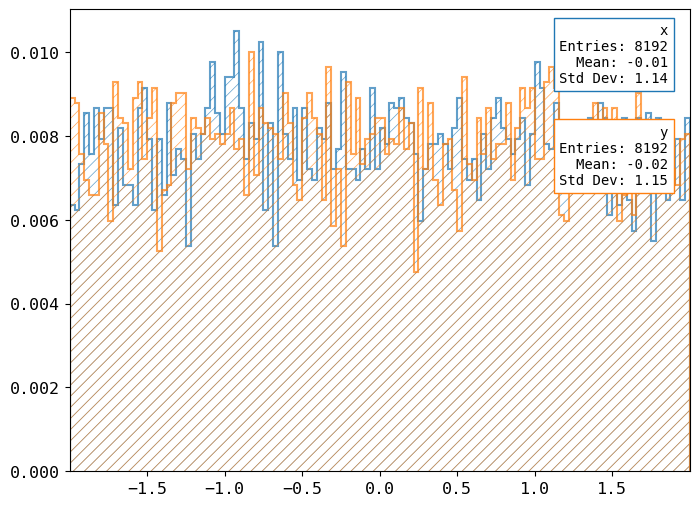

In [73]:
nfm = get_nfm(q0=a, hidden_units=128)
plot_proposal(nfm, n_samples=8192)

In [74]:
def func(args):
    return torch.exp(-1*torch.sqrt(args.T[0]**2 + args.T[1]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)

In [75]:
get_result(a, func, is_nfm=False, n_samples=10000)

(4.029300689697266, 0.025156553834676743)

In [76]:
get_result(nfm, func)

(4.1179399490356445, 0.08145259320735931)

In [77]:
samples, log_p = nfm.sample(1000)
results = func(samples).detach().cpu().numpy()

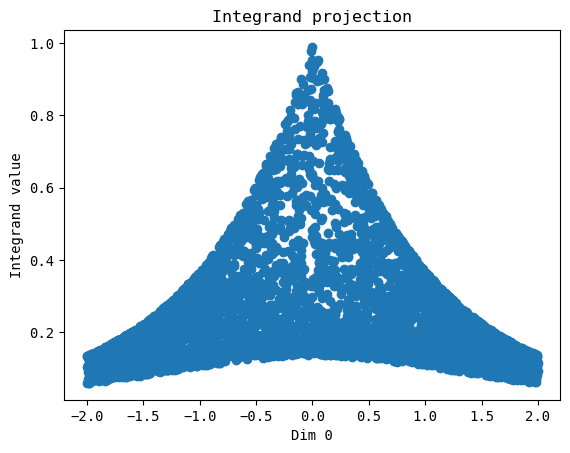

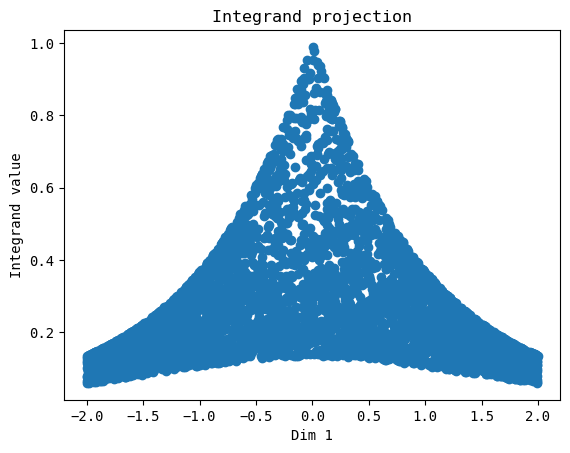

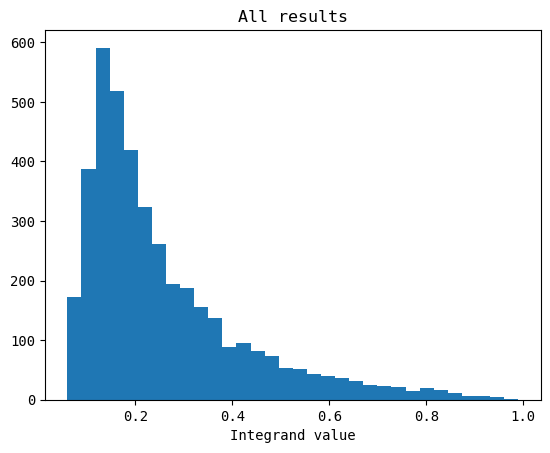

In [78]:
plot_integrand(nfm, func, n_samples=4096)

In [79]:
def train_iflow(nfm, func, n_samples:int=10000, n_epochs:int=20, lr:float=1e-4):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=lr)
    for i in range(n_epochs):
        optimizer.zero_grad()
        
        z, logq = nfm.q0(n_samples)
        true = torch.abs(func(z)).detach()
        logp = torch.where(true > 1e-16, true.log(), true + 1e-16).detach()
        
        # Transform through NFlow
        for flow in nfm.flows:
            z, log_det = flow(z)
            logq -= log_det
        
        test = logq.exp().detach()
        
        mean = torch.mean(true/test)
        var = torch.var(true/test)
        
        true = true/mean
        loss = (1/n_samples) * ((true/test) * (logp - logq)**2).sum()
        
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()} | Var {var}")
        
def train_backward(nfm, func, n_samples:int=32000, n_epochs:int=10):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3)
    p = nfm.q0.log_prob_val.exp()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        samples, log_p = nfm.sample(n_samples)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(p*prob)) * results**2).sum()
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()}")

In [88]:
#train_forward(nfm, func, n_epochs=10)
train_iflow(nfm, func, n_epochs=10)

Epoch 0: 0.11835969984531403 | Var 0.13037273287773132
Epoch 1: 0.06725388765335083 | Var 0.06017027050256729
Epoch 2: 0.05215194448828697 | Var 0.045032043009996414
Epoch 3: 0.03515823557972908 | Var 0.03312915191054344
Epoch 4: 0.03354958817362785 | Var 0.03383004665374756
Epoch 5: 0.03350144624710083 | Var 0.03411177545785904
Epoch 6: 0.03272650018334389 | Var 0.03314117714762688
Epoch 7: 0.03233214095234871 | Var 0.03284681588411331
Epoch 8: 0.02713109739124775 | Var 0.02739957720041275
Epoch 9: 0.024631811305880547 | Var 0.023538291454315186


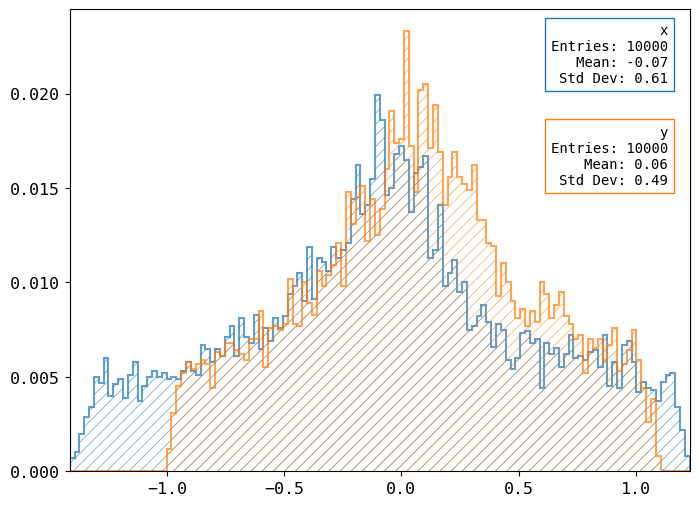

In [89]:
plot_proposal(nfm, n_samples=10000)

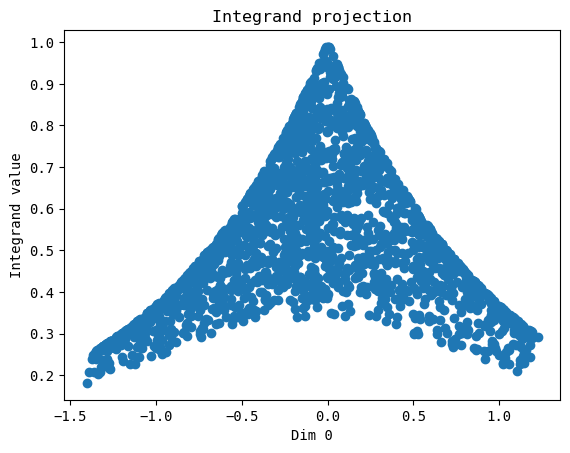

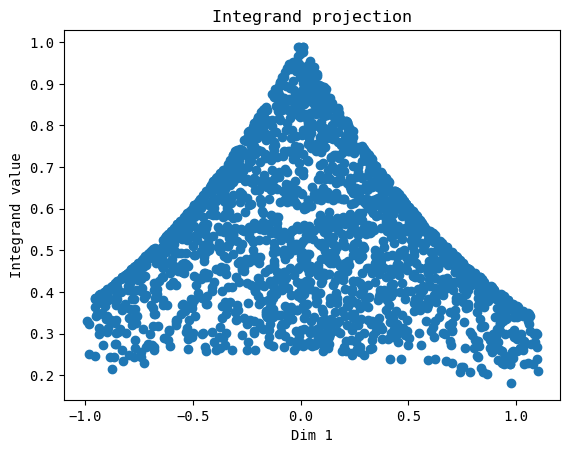

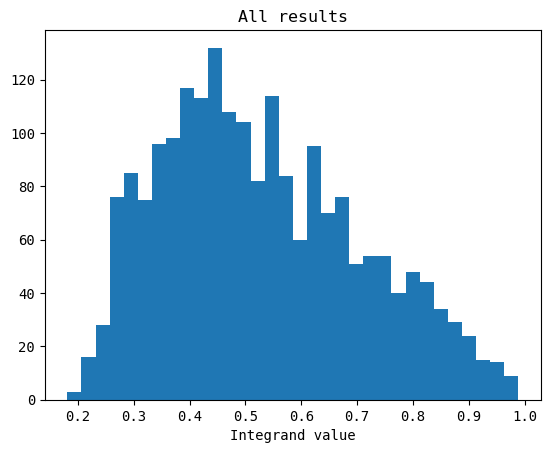

In [90]:
plot_integrand(nfm, func, y_log=False)

In [91]:
get_result(nfm, func, n_samples=4096)

(2.2560036182403564, 0.010856494307518005)

In [96]:
n_samples = 100

samples, logq = nfm.sample(n_samples)
true = torch.abs(func(samples.detach()))
test = logq.exp()
mean = torch.mean(true/test)
var = torch.var(true/test)

print(mean, torch.sqrt(var/(n_samples-1.)).item())

tensor(2.2204, grad_fn=<MeanBackward0>) 0.072452612221241


In [93]:
4.01/2.3243

1.7252506130878114

In [86]:
from math import sqrt

In [87]:
sqrt(1.72525)

1.3134877235817624